## Faltung ##

Dieses Notebook demonstriert die Faltung interaktiv. Die diskrete Faltung ist definiert durch
$$
y[n] = x[n] \ast h[n] = \sum_{i = -\infty}^{+\infty} x[i] h[n-i]
$$

Man kann sich diesen Vorgang so vorstellen, dass die Impulsantwort $h[n]$ über das Signal $x[n]$ geschoben wird:

**Beispiel**: $h[n] = \delta[n] = \begin{cases} 1 \text{ für }n=0 \\0 \text{ sonst.}\\ \end{cases}$ (Diracstoß)  und  $x[n] = \{1; 2; 3\}$.

$n = 0\, \rightarrow \, y[0] = x[0] \cdot 1 = 1$;  $n = 1\; \rightarrow \, y[1] = x[1] \cdot 1 = 2$; $n = 2\, \rightarrow \, y[2] = x[2] \cdot 1 =3$; $y$ ist ansonsten $0$.

Hier zeigt sich die Siebeigenschaft des Diracstoßes: Nur wenn das Argument 0 ist ($i = n$), liefert der Diracstoß einen Beitrag, er siebt quasi den zugehörigen Wert $x[n]$ aus.

Ein System mit der Impulsantwort $h[n] = \{1; 2\}$ kann man sich als die Überlagerung zweier zeitversetzter Systeme $h_1[n] = \delta[n]$ und $h_2[n] = 2 \delta[n-1]$ vorstellen. Das funktioniert nur für lineare, zeitinvariante Systeme, daher ist die Faltung auch nur für LTI-Systeme definiert. Für das Signal $x[n] = \{1; 2; 3\}$ erhält man:

$$
n = 0\, \rightarrow \, y[0] = \ldots + \underbrace{x[-1]h[1]}_{= 0} + \underbrace{x[0]h[0]}_{=1} + \underbrace{x[1]h[-1]}_{=0} + \ldots = 1
$$

$$
n = 1\, \rightarrow \, y[1] = \ldots + \underbrace{x[-1]h[2]}_{= 0} + \underbrace{x[0]h[1]}_{=2} + \underbrace{x[1]h[0]}_{=2} + \ldots = 4
$$

$$
n = 2\, \rightarrow \, y[2] = \ldots  + \underbrace{x[0]h[2]}_{=0} + \underbrace{x[1]h[1]}_{=4} +  \underbrace{x[2]h[0]}_{=3} + \ldots = 7
$$

$$
n = 3\, \rightarrow \, y[3] = \ldots  + \underbrace{x[1]h[2]}_{=0} + \underbrace{x[2]h[1]}_{=6} +  \underbrace{x[3]h[0]}_{=0} + \ldots = 6
$$

$y$ ist ansonsten $0$.


Diese Art die Faltung zu berechnen eignet sich vor allem für Systeme mit kurzer Impulsantwort und für lange Eingangsfolgen, da immer nur ein paar Samples von $x[n]$ zur Rechnung beitragen. Da die Faltung kommutativ ist, kann man z.B. für kurze Eingangsfolgen auch die "umgedrehte" Variante verwenden:
$$
y[n] = h[n] \ast x[n] = \sum_{i = -\infty}^{+\infty} h[i] x[n-i]
$$


In [1]:
#%matplotlib inline
# "inline" renders using inline png graphics
import sys
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import animation
from IPython.display import HTML
from IPython import __version__ as ipy_version

sys.path.append('../')
import dsp_fpga_lib as dsp
dsp.versions()
print("IPython:", ipy_version)

plt.rcParams.update(dsp.mpl_rc) # define plot properties 
plt.rcParams['figure.figsize'] = (5,5)

Python version: 3.7.4
Numpy: 1.15.0
Scipy: 1.1.0
Matplotlib: 3.1.1 module://ipykernel.pylab.backend_inline
IPython: 7.11.1


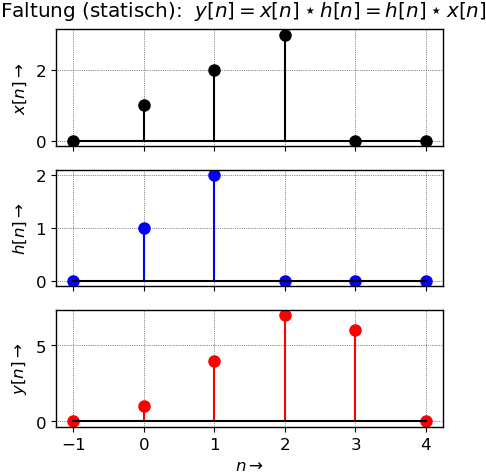

In [2]:
# Convolution 1: x * h -> slide h along x
# define signal and impulse response here
#h = [1, 1, 1, 1, 1, 1] # impulse response
h = [1, 2]

x = [1, 2, 3] # input signal

y = np.convolve(x, h)
L = len(y)+2 # max. total length plus one sample padding on both sides

# create padded arrays padded with identical lengths for static plotting
len_h = len(h) # length of impulse response
len_x = len(x) # length of input signal
n = np.arange(L)-1 # index runs from n = -1 to L-2
xp = np.pad(x, (1, L-len_x-1), 'constant', constant_values=(0,0))# fill up with zeros 
hp = np.pad(h, (1, L-len_h-1), 'constant', constant_values=(0,0))# for total length of L
yp = np.pad(y, (1, 1), 'constant', constant_values=(0,0)) # to plot all in a common figure

# First set up the figure, the axis, and the plot element(s) we want to animate. %%caption suppresses blank window
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
ax[0].stem(n, xp, 'k-', 'ko', 'k', use_line_collection=True) # input signal
ax[1].stem(n, hp, 'b-', 'bo', 'k', use_line_collection=True) # impulse response
ax[2].stem(n, yp, 'r-', 'ro', 'k', use_line_collection=True) # output signal

fig.suptitle(r'Faltung (statisch):  $y[n] = x[n] \star h[n] = h[n] \star x[n]$')
ax[0].set_ylabel(r'$x[n] \rightarrow$')
ax[1].set_ylabel(r'$h[n] \rightarrow$')
ax[2].set_ylabel(r'$y[n] \rightarrow$')
ax[2].set_xlabel(r'$n \rightarrow$');
fig.subplots_adjust(top=0.92);
x_ylim = ax[0].get_ylim()
h_ylim = ax[1].get_ylim()
y_ylim = ax[2].get_ylim()

In [3]:
# create zero padded copies for animation plotting
x_i = np.pad(x, (len_h, len_h), 'constant', constant_values=(0,0))
L_i = len(x_i)
h_i = np.pad(h[::-1], (L_i, L_i), 'constant', constant_values=(0,0)) # reverse h and pad it 
k = np.arange(-len_h, L_i-len_h)

def init():
    # this is called twice at the beginning by matplotlib
    y_i = np.zeros(2*L_i)
    ax[0].cla()
    ax[0].stem(k, x_i, 'k-', 'ko', 'k', use_line_collection=True) # input signal 
    ax[0].set_ylabel(r'$x[n] \rightarrow$');
    fig.suptitle(r'Faltung $y[n] = x[n] \star h[n]$')

def animate_h(n):
    print(n,'.', end='', sep='') # suppress endline terminator and white space between numbers
    h_k = h_i[L_i - n:2*L_i - n]
    ax[1].cla()
    ax[1].stem(k, h_k , 'b-', 'bo', 'b', use_line_collection=True) # x[-2] is second element from the end
    ax[1].set_ylabel(r'$h[n-i] \rightarrow$')
    y_i[n+len_h-1] = np.sum(x_i * h_k)
    ax[2].cla()
    ax[2].stem(k, y_i[:L_i], 'r-', 'ro', 'r', use_line_collection=True)
    ax[2].scatter(n-1, y_i[n+len_h-1], s=(plt.rcParams['lines.markersize']*1.5)**2, c='darkgreen', alpha=0.5)
    ax[2].text(0.05,0.8,"n = {0:d}".format(n-1),transform=ax[2].transAxes, fontsize=14, ha='left', va='center',
              bbox={'alpha':0.5, 'color':'wheat'})
    ax[2].set_ylim(y_ylim)
    ax[2].set_xlabel(r'$i,\, n\, \rightarrow$');
    ax[2].set_ylabel(r'$y[n] \rightarrow$');

y_i = np.zeros(2*L_i)

ani = animation.FuncAnimation(fig, animate_h, frames=L_i-1, init_func=init)
ani

0.1.2.3.4.5.

**Aufgaben:**
- Spielen Sie mit verschiedenen Eingangssignalen und Impulsantworten herum

***
**Copyright**

(c) 2016 - 2018 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp_fpga "Digitale Signalverarbeitung auf FPGAs"

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing auf FPGAs - Vorlesungsunterlagen mit Simulationsbeispielen, 2018*.